In [3]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 39.4 MB/s 
     |████████████████████████████████| 46 kB 3.0 MB/s 
     |████████████████████████████████| 189 kB 30.9 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 51 kB 114 kB/s 
Mounted at /content/gdrive


In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Data gathering

In [6]:
#we use the bing image search api
key = os.environ.get('AZURE_SEARCH_KEY', '3dcd122069db42fc9c51da3c8e9d4f58')

results = search_images_bing(key, 'grizzly bear') #max_images=150
ims = results.attrgot('contentUrl')
len(ims)

150

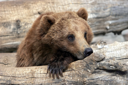

In [8]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [22]:

bear_types = 'grizzly','black','teddy'
path = Path('bears')

path.mkdir(exist_ok=True)
for b in bear_types:
    dest = (path/b)
    print()
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{b} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))


In [27]:
#we make sure that there are 150 images for each category

for b in bear_types:
  dir = "bears/"+b
  print(b, len([name for name in os.listdir(dir)]))

grizzly 142
black 147
teddy 149


The data is a bit unbalanced but nothing very significant

In [29]:
#let's verify that the downloaded images are not corrupt
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/00000101.png')]

In [30]:
#let's remove the failed images
failed.map(Path.unlink);

In [31]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [32]:
dls = bears.dataloaders(path)

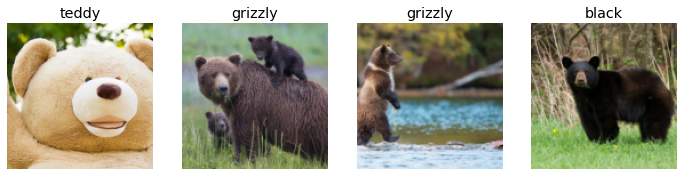

In [33]:
dls.valid.show_batch(max_n=4, nrows=1)

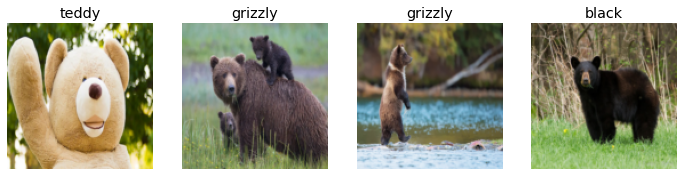

In [34]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

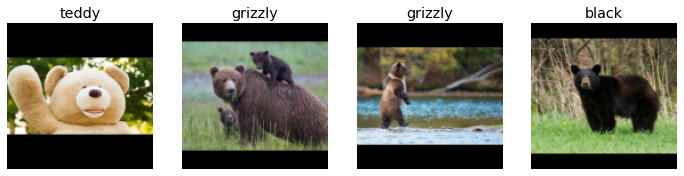

In [35]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

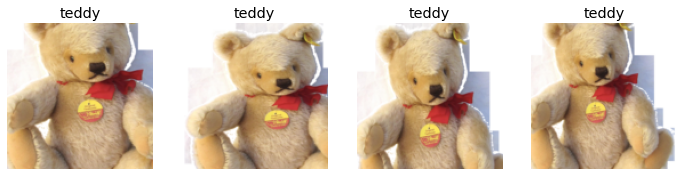

In [39]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [40]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [41]:
#we learn with these dataloaders, with an initialized network resnet18 and 4 epochs
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.406188,0.141206,0.068966,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.192794,0.078535,0.022989,01:59
1,0.123293,0.068834,0.011494,01:57
2,0.084233,0.065539,0.011494,01:57
3,0.064387,0.062522,0.011494,01:57


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a confusion matrix:

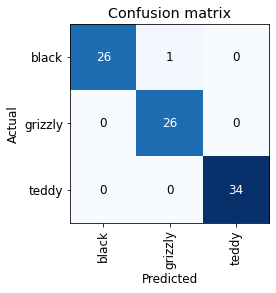

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

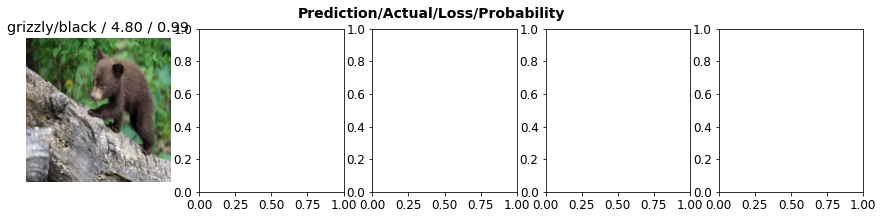

In [43]:
#let's visualize the main mistakes

interp.plot_top_losses(5, nrows=1)

In [49]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [50]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [44]:
#we export the model
learn.export()

In [45]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [46]:
learn_inf = load_learner(path/'export.pkl')

In [47]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.6645e-07, 1.0000e+00, 7.4307e-07]))

In [48]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [61]:
# we build an app using widgets to select and image, print it and get a prediction

btn_run = widgets.Button(description='Classify')

#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
#with out_pl: display(img.to_thumb(128,128))

btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])
img = PILImage.create(btn_upload.data[-1])

pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
#bl_pred


def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [62]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [63]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])